# Physics of a single pendulum

The goal of this notebook is to familiarise ourselves with calculations of
motion of a single pendulum of length l, and mass m.

The following assumptions are made about the pendulum:
* The cord holding the mass is infinitely thin, rigid and without mass
* The mass is focused in a single point at the end of the cord
* There is no damping force (air resistance, friction)
* Motion is in the $Oxy$ plane

## Determining the differential equations of motion

To find the differential equations, we will be using `SymPy`, and it's
`sympy.physics.mechanics` module. To do that, we must first import it:

# The motion of a single pendulum

In [25]:
from sympy.physics import mechanics
import sympy as sym
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### The free-body diagram

The pendulum hangs at the end of a cord of length $l$.
Since the cord cannot be extended, bent, or contracted, we know that it's
length is constant.

That means the center of mass is on a circle with radius $l$, and the center
of the circle is at the pivot.

The reference frame we'll use uses the pivot as the origin $O$, the $Oy$ axis
will be directed _downwards_ (toward the pendulum's equilibrium position), and
the $Ox$ axis will be $90^{\circ}$ counter-clockwise from the $Oy$ axis.

This way, we can express the position of the pendulum, $P(x, y)$ using polar
coordinates with radius $l$ and some angle $\theta$, which we'll define as
the angle between the vector $\vec{OP}$ and the $Oy$ axis:
\begin{equation*}
(x, y) = (l \cos \theta, l \sin \theta)
\end{equation*}

Since the cord's length $l$ is a property of the pendulum, we have a single
degree of freedom, and that is the angle $\theta$.

Along with the length and the initial angle, $\theta_0$, we also need to know
the mass of the pendulum $m$, and these are our initial conditions (with the
length and mass being specific to the pendulum, and thus constant).

In [26]:
m = sym.Symbol('m')
l = sym.Symbol('l')

Now we'll also define some required symbols, namely $g$, which is the
gravitational acceleration, and $t$, which stands for time

In [27]:
g, t = sym.symbols('g t')

Next, we define the angle $\theta$ and the angular speed $\omega$.
Note that $\omega$ is the time derivative of the angle $\theta$.
We will establish this connection later in the code.

In [28]:
theta, omega = mechanics.dynamicsymbols('theta omega')
d_theta, d_omega = mechanics.dynamicsymbols('theta omega', level=1)

Now we create the reference frame:

In [29]:
Oxy = mechanics.ReferenceFrame('Oxy')
O = mechanics.Point('O')  # pivot

# since the pivot is constant in the frame Oxy, we set it's velocity to 0
O.set_vel(Oxy, 0)

# We create the local coordinate system of the pendulum (A) with the same center
# However, we rotate it so that it's Ay axis is in the direction of the pendulum
A = Oxy.orientnew('A', rot_type='axis', amounts=[theta, Oxy.z])

# Now we specify the location of the pendulum
P = O.locatenew('P', l * A.y)
# And create its particle (of mass m)
particleP = mechanics.Particle('paP', P, m)

Now we specify the kinematic differential equations: here we tell `SymPy` that
the angular speed is the time derivative of the angle.

We do this by specifying the equation:

\begin{equation*}
\frac{d \theta}{d t} - \omega = 0
\end{equation*}

In [30]:
kde = d_theta - omega
kde_dict = { d_theta: omega }

Now we start registering the velocities and registering forces.
The only force is gravity, pulling "downwards" (towards $Oy$), with the
intensity $mg$.

We will specify angular velocity by rotating the local coordinate system,
and keeping $P$ fixed.

In [31]:
F = m * g * Oxy.y

A.set_ang_vel(Oxy, omega * Oxy.z)
P.v2pt_theory(O, Oxy, A);

With this, we have fully described the motion diagram, and will now instruct
`SymPy` to generate the ordinary differential equations (ODEs), which we can
later solve numerically using `scipy`.

In [32]:
KM = mechanics.KanesMethod(Oxy, q_ind=[theta], u_ind=[omega],
                           kd_eqs=[kde])
(fr, frstar) = KM.kanes_equations([particleP], [(P, F)])

We can now generate the ODEs and display them:

In [33]:
MM = KM.mass_matrix
forcing = KM.forcing
rhs = MM.inv() * forcing
kdd = KM.kindiffdict()
rhs = rhs.subs(kdd)
rhs.simplify()
rhs

Matrix([[-g*sin(theta(t))/l]])

In order to use the result to calculate the motion, the process is a bit
different:

In [34]:
parameters = [g, l, m]

unknowns = [sym.Dummy() for i in [theta, omega]]
unknown_dict = { theta: unknowns[0], omega: unknowns[1] }
kds = KM.kindiffdict()
mm_full_symbols = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
fo_full_symbols = KM.forcing_full.subs(kds).subs(unknown_dict)

mm_func = sym.lambdify(unknowns+parameters, mm_full_symbols, 'numpy')
fo_func = sym.lambdify(unknowns+parameters, fo_full_symbols, 'numpy')

def gradient(y, t, args):
    vals = np.concatenate((y, args))
    sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
    return np.array(sol).T[0]

## Calculating and displaying the results

In order to display the results, we will need to get the $x$ and $y$
coordinates from the length and angle.

In [35]:
def get_xy_coords(cord_length, angles):
    x = np.sin(angles-np.pi) * cord_length
    y = -np.cos(angles) * cord_length
    return x, y

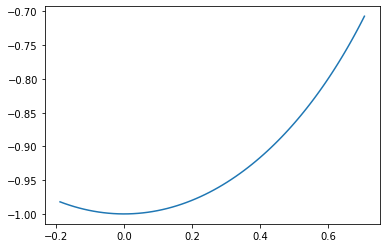

In [36]:
mass = 1.0
times = np.linspace(0, 0.6, 100)
length = 1.0
initial_angle = np.deg2rad(-45)
initial_speed = 0.01
angles = odeint(gradient, [initial_angle, initial_speed], times,
                args=([9.81, length, mass],))
x, y = get_xy_coords(length, angles[:,0])
plt.plot(x,y)
